In [1]:
import torch; 
print(torch.__version__, torch.cuda.is_available())

2.0.0+cu117 True


In [159]:
import cv2
import torch
import time
import os
import numpy as np

from utils.inference.image_processing import crop_face, get_final_image, show_images, get_only_swaped_image
from utils.inference.video_processing import read_video, get_target, get_final_video, add_audio_from_another_video, face_enhancement
from utils.inference.core import model_inference

from network.AEI_Net import AEI_Net
from coordinate_reg.image_infer import Handler
from insightface_func.face_detect_crop_multi import Face_detect_crop
from arcface_model.iresnet import iresnet100
from models.pix2pix_model import Pix2PixModel
from models.config_sr import TestOptions

### Load Models

In [160]:
app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

# main model for generation
G = AEI_Net(backbone='unet', num_blocks=2, c_id=512)
G.eval()
G.load_state_dict(torch.load('weights/G_unet_2blocks.pth', map_location=torch.device('cpu')))
G = G.cuda()
G = G.half()

# arcface model to get face embedding
netArc = iresnet100(fp16=False)
netArc.load_state_dict(torch.load('arcface_model/backbone.pth'))
netArc=netArc.cuda()
netArc.eval()

# model to get face landmarks
handler = Handler('./coordinate_reg/model/2d106det', 0, ctx_id=0, det_size=640)

# model to make superres of face, set use_sr=True if you want to use super resolution or use_sr=False if you don't
# 超解像度を使用する場合はuse_sr=Trueを、使用しない場合はuse_sr=Falseを設定する。
use_sr = False
if use_sr:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.backends.cudnn.benchmark = True
    opt = TestOptions()
    #opt.which_epoch ='10_7'
    model = Pix2PixModel(opt)
    model.netG.train()

input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)
loading ./coordinate_reg/model/2d106det 0
input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)


[14:54:08] /work/mxnet/src/nnvm/legacy_json_util.cc:208: Loading symbol saved by previous version v1.5.0. Attempting to upgrade...
[14:54:08] /work/mxnet/src/nnvm/legacy_json_util.cc:216: Symbol successfully upgraded!


### Set here path to source image and video for faceswap

In [157]:
"""
choose not really long videos, coz it can take a lot of time othervise 
choose source image as a photo -- preferable a selfie of a person
"""
image_to_image = True

if image_to_image:
    path_to_target = 'examples/images/003.jpg'
else:
    path_to_video = 'examples/videos/random_gif.gif'
source_full = cv2.imread('examples/images/hibiki.jpg')
OUT_VIDEO_NAME = "examples/results/result.mp4"
crop_size = 224 # don't change this
BS = 60


# check, if we can detect face on the source image
try:    
    source = crop_face(source_full, app, crop_size)[0]
    source = [source[:, :, ::-1]]
    print("Everything is ok!")
except TypeError:
    print("Bad source images")

# read video and find target image in the video that contains at least 1 face
if image_to_image:
    target_full = cv2.imread(path_to_target)
    full_frames = [target_full]
    print(len(full_frames))
else:
    full_frames, fps = read_video(path_to_video)
target = get_target(full_frames, app, crop_size)

# Model Inference
START_TIME = time.time()
final_frames_list, crop_frames_list, full_frames, tfm_array_list = model_inference(full_frames,
                                                                                   source,
                                                                                   target,
                                                                                   netArc,
                                                                                   G,
                                                                                   app,
                                                                                   set_target = False,
                                                                                   crop_size=crop_size,
                                                                                   BS=BS)

Everything is ok!
1


100%|██████████| 1/1 [00:00<00:00, 18.99it/s]
1it [00:00, 351.72it/s]
1it [00:00, 5706.54it/s]
100%|██████████| 1/1 [00:00<00:00, 22075.28it/s]


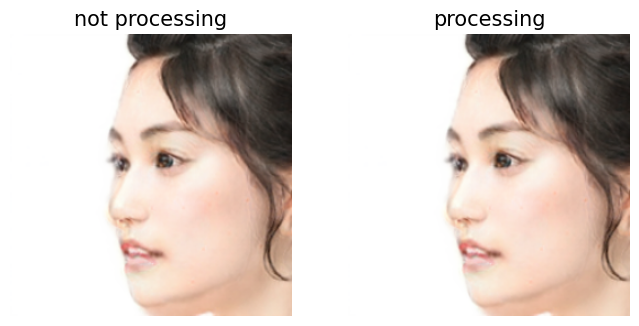

/home/ubuntu-gpu/project/laboratory/ghost/.venv/lib/python3.8/site-packages/mxnet/ndarray/utils.py:141: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  if spsp is not None and isinstance(source_array, spsp.csr.csr_matrix):
/home/ubuntu-gpu/project/laboratory/ghost/.venv/lib/python3.8/site-packages/mxnet/ndarray/utils.py:141: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  if spsp is not None and isinstance(source_array, spsp.csr.csr_matrix):


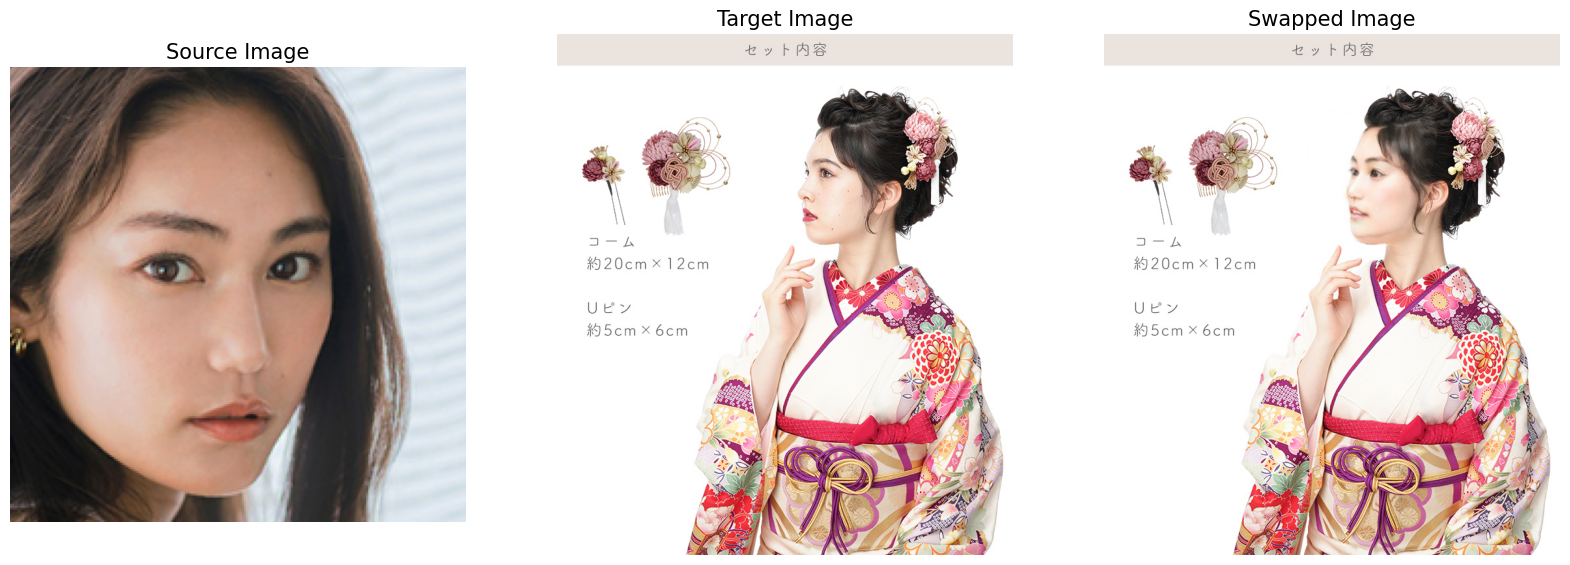

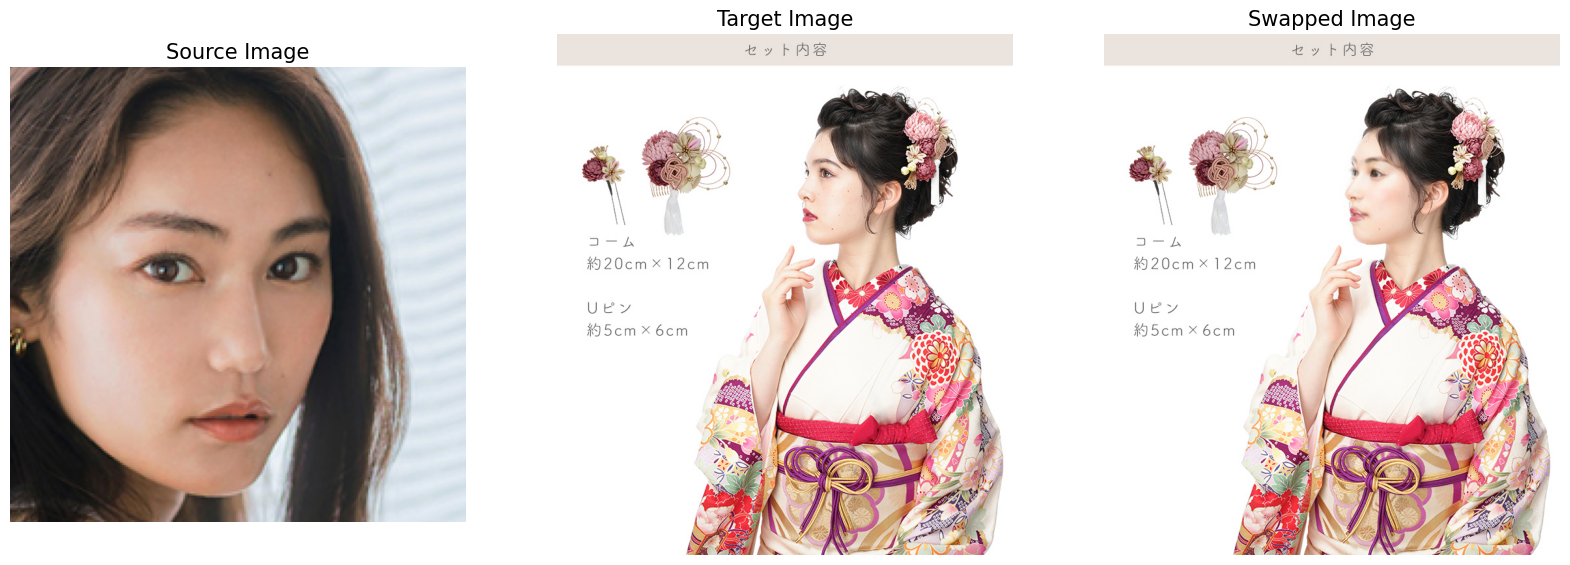

In [158]:
from typing import List
import numpy as np
import matplotlib.pyplot as plt

def show_face_frames(final_frames_list: List[List[np.ndarray]], 
                      titles: List[str] = None, 
                      figsize: tuple = (20, 5), 
                      fontsize: int = 15):
    """
    オプションのタイトルと共に最終フレームを表示する

    Args:
    final_frames_list (List[List[np.ndarray]]): 最終フレームのリストのリスト
    titles (List[str], optional): 各セットのタイトル。デフォルトはNone
    figsize (tuple, optional): 図のサイズ。デフォルトは(20, 5)
    fontsize (int, optional): タイトルのフォントサイズ。デフォルトは15
    """

    fig, axes = plt.subplots(1, len(final_frames_list), figsize=figsize)
    for idx, (ax, image) in enumerate(zip(axes, final_frames_list)):
        ax.imshow(image[0][:, :, ::-1])
        if titles:
            ax.set_title(titles[idx], fontsize=fontsize)
        ax.axis("off")
    plt.show()

def get_only_swaped_fullimage(final_frames: List[np.ndarray],
                          crop_frames: List[np.ndarray],
                          full_frame: np.ndarray,
                          tfm_arrays: List[np.ndarray]):
    """
    フェイススワッピングや他の画像変換の結果を用いて最終的な画像を生成する

    Args:
    final_frames (List[np.ndarray]): 最終的に生成されたフレームのリスト
    full_frame (np.ndarray): フルサイズの元のフレーム
    tfm_arrays (List[np.ndarray]): 各フレームに適用された変換行列のリスト
    """
    final = full_frame.copy()
    
    for frames, crop_frames, tfm_arrays in zip(final_frames_list, crop_frames_list, tfm_array_list):
        for frame, crop_frame, tfm_array in zip(frames, crop_frames, tfm_arrays):
            if frame.size > 0:
                frame_resized = cv2.resize(frame, (crop_frame.shape[1], crop_frame.shape[0]))
                mat_rev = cv2.invertAffineTransform(tfm_array)
                swap_t = cv2.warpAffine(frame_resized, mat_rev, (full_frame.shape[1], full_frame.shape[0]), borderMode=cv2.BORDER_REPLICATE)
                mask = cv2.warpAffine(np.ones_like(crop_frame[:, :, 0], dtype=np.uint8), mat_rev, (full_frame.shape[1], full_frame.shape[0]))
                mask = mask[:, :, np.newaxis]
                final = mask * swap_t + (1 - mask) * final
    
    final = np.array(final, dtype='uint8')
    return final
# １．顔のクローズアップ
face_close_up = final_frames_list.copy()

# 超解像処理
if use_sr:
    final_frames_list = face_enhancement(final_frames_list, model)

# 表示するタイトルを指定します
titles = ["not processing", "processing"]
face_close_up.append(final_frames_list[0])

# 画像として表示します
show_face_frames(face_close_up, titles, figsize=(8, 5))

# ２．全体
# 後処理なし
result = get_only_swaped_fullimage(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list)
show_images([source[0][:, :, ::-1], target_full, result], ['Source Image', 'Target Image', 'Swapped Image'], figsize=(20, 15))

# 後処理あり
result = get_final_image(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list, handler)
show_images([source[0][:, :, ::-1], target_full, result], ['Source Image', 'Target Image', 'Swapped Image'], figsize=(20, 15))


In [13]:
# 各変数のデータ構造と値をプリント
print("Final Frames List:")
print(f"Type: {type(final_frames_list)}")
for i, frames in enumerate(final_frames_list):
    print(f"Frame {i}:")
    print(f"Type: {type(frames)}")
    for frame in frames:
        if isinstance(frame, np.ndarray):
            print(f"Shape: {frame.shape}")
        print(frame)

print("\nCrop Frames List:")
print(f"Type: {type(crop_frames_list)}")
for i, frames in enumerate(crop_frames_list):
    print(f"Crop Frame {i}:")
    print(f"Type: {type(frames)}")
    for frame in frames:
        if isinstance(frame, np.ndarray):
            print(f"Shape: {frame.shape}")
        print(frame)

print("\nFull Frames:")
print(f"Type: {type(full_frames)}")
for i, frame in enumerate(full_frames):
    print(f"Full Frame {i}:")
    if isinstance(frame, np.ndarray):
        print(f"Shape: {frame.shape}")
    print(frame)

print("\nTransformation Array List:")
print(f"Type: {type(tfm_array_list)}")
for i, tfm_array in enumerate(tfm_array_list):
    print(f"Transformation Array {i}:")
    print(f"Type: {type(tfm_array)}")
    if isinstance(tfm_array, np.ndarray):
        print(f"Shape: {tfm_array.shape}")
    print(tfm_array)

Final Frames List:
Type: <class 'list'>
Frame 0:
Type: <class 'list'>
Shape: (256, 256, 3)
[[[ 81  83  82]
  [ 83  86  87]
  [ 82  87  90]
  ...
  [ 91  91  90]
  [ 92  90  90]
  [ 93  89  87]]

 [[ 84  86  87]
  [ 86  89  91]
  [ 87  91  94]
  ...
  [ 93  90  88]
  [ 93  91  89]
  [ 92  89  88]]

 [[ 93  93  96]
  [ 89  92  96]
  [ 88  91  96]
  ...
  [ 92  88  87]
  [ 92  88  87]
  [ 90  87  87]]

 ...

 [[214 205 208]
  [218 210 214]
  [222 215 221]
  ...
  [135 140 140]
  [132 138 140]
  [132 138 140]]

 [[207 199 201]
  [219 209 211]
  [225 216 220]
  ...
  [134 139 140]
  [133 139 140]
  [136 141 144]]

 [[201 194 196]
  [223 213 214]
  [228 217 221]
  ...
  [133 137 139]
  [134 139 141]
  [136 143 145]]]

Crop Frames List:
Type: <class 'list'>
Crop Frame 0:
Type: <class 'list'>
Shape: (224, 224, 3)
[[[ 87  87  87]
  [ 85  87  88]
  [ 83  87  91]
  ...
  [ 90  88  87]
  [ 93  90  89]
  [ 93  89  88]]

 [[ 86  85  86]
  [ 84  85  89]
  [ 85  88  95]
  ...
  [ 91  88  87]
  [ 92  8